[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Custom spatial aggregation of CF data

This notebook aims to provide an overview on how Transmission System Operators (TSOs) can implement customized spatial aggregations within the Pan-European Climate Database version 4.2 ([PECDv4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)) data, particularly with regard to weighting by the installed capacity (IC) of a given technology.

SPV is used here as an example to clarify the dataset’s default spatial aggregation and to provide TSOs with the know-how to switch to other spatial aggregations.

For illustration purposes, this notebook uses a short temporal subsample of the PECDv4.2 dataset. This approach is intended to demonstrate the workflow and methodology rather than to produce robust, policy-relevant impact assessments.
It is important to emphasize that for rigorous climate impact studies, the use of such limited data is not sufficient. Reliable analyses should be based on longer time series (typically at least 30 years).  
In this example, we will download and read aggregated NUTS 2 data in CSV format for utility-scale fixed PV in 2020 / historical stream and use France as a case study. In principle, this workflow can be extended to include multiple years, climate projection periods (2015–2100), and other energy technologies.

## Learning objectives 🧠

In this notebook, you will learn on **how to generate NUTS 0 data using finer NUTS 2 data and a IC-based weighting**. You will also understand the way SPV data in the PECD is aggregated and its limitations.

## Target Audience 🎯

**Anyone** interested in custom spatial aggregation of solar generation capacity factors from PECD 4.2 using CSV data and region-based weighting.

## Prepare your environment

### Import libraries

In the following we will import six libraries: the [os](https://docs.python.org/3/library/os.html) module provides functions to interact with the operating system, especially for file and directory operations. It allows the script to build portable file paths, list contents of folders, or check if files exist. The [pandas](https://pandas.pydata.org/docs/) module provides a way to read, handle, and visualize tabular data; the [numpy](https://numpy.org/doc/stable) module is here used to generate sequence of float values; and the [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) module allows us to generate and edit standard visualizations, whereas [geopandas](https://geopandas.org/en/stable/) excels in spatial data editing and plotting. [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) is a Python library that provides programmatic access to the Copernicus Climate Data Store (CDS), allowing you to download the relevant data for this work.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cdsapi

### Set up the CDS API and your credentials

This step is essential to be able to download the data. For a complete walkthrough of downloading data from the Climate Data Store (CDS) via the CDS API, see the notebook [*Downloading PECDv4.2 data from the CDS via cdsapi*](./download-data-from-cds.ipynb).

If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes ```"your_api_key"```). Your token can be found on the [CDS portal](https://cds.climate.copernicus.eu/profile) (you will need to log in to see your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [ ]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

In this example, we use data from PECD version “PECD4.2” for the “Historical” temporal stream, derived from ERA5 reanalysis. The selected variable is the “solar photovoltaic generation capacity factor”, retrieved for the year 2020 at "NUTS 2" spatial resolution (find more about NUTS on [Eurostat](https://ec.europa.eu/eurostat/web/nuts)) and covering the photovoltaic technology "62 (SPV utility-scale fixed)", i.e. large, ground-based installations with fixed Si modules.

The API request reflecting these selections is shown in the next cell.

In [ ]:
# Historical ERA5 – solar PV capacity factor for 2020, four technologies at NUTS 2
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "year": ["2020"],
    "variable": ["solar_photovoltaic_generation_capacity_factor"],
    "technology": ["62"],
    "spatial_resolution": ["nuts_2"],
}

Next, we will create a dedicated folder to store our data, call the retrieve method and unzip the downloaded data to be ready to use our CSV file.

In [4]:
# create folder
input_dir = "cds_data/custom_spatial_aggregation/"
os.system(f"mkdir -p {input_dir}")

# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/spv_csa_data.zip")

# Unzipping every file in our folder
zip_path = os.path.join(input_dir, "spv_csa_data.zip")
os.system(f"unzip {zip_path} -d {input_dir}")

2025-08-27 09:36:57,333 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-27 09:37:01,894 INFO Request ID is 176aae47-85d5-40fc-b00e-0e86d021108c
2025-08-27 09:37:01,961 INFO status has been updated to accepted
2025-08-27 09:37:23,196 INFO status has been updated to running
2025-08-27 09:43:20,443 INFO status has been updated to successful
replace cds_data/custom_spatial_aggregation/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT2_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_62_NA---_NA---_PhM03_PECD4.2_fv1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Archive:  cds_data/custom_spatial_aggregation/spv_csa_data.zip


20480

## Read the data

We are now ready to load the data. The next code cell displays a small subset of the CSV so we can take a first look at how the data are structured.

In [17]:
# spv_utility_fix, 2020 (as an example)
filename = (
    "H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT2_S202001010000_E202012312300_"
    "CFR_TIM_01h_COM_noc_org_62_NA---_NA---_PhM03_PECD4.2_fv1.csv"
)

df = pd.read_csv(
    input_dir + filename, comment="#", delimiter=",", index_col=["Date"], parse_dates=["Date"]
)
df.iloc[:9, 10:15]

AT11     AT12    AT13     AT21     AT22
Date                                                           
2020-01-01 00:00:00  0.00000  0.00000  0.0000  0.00000  0.00000
2020-01-01 01:00:00  0.00000  0.00000  0.0000  0.00000  0.00000
2020-01-01 02:00:00  0.00000  0.00000  0.0000  0.00000  0.00000
2020-01-01 03:00:00  0.00000  0.00000  0.0000  0.00000  0.00000
2020-01-01 04:00:00  0.00000  0.00000  0.0000  0.00000  0.00000
2020-01-01 05:00:00  0.00000  0.00000  0.0000  0.00000  0.00000
2020-01-01 06:00:00  0.00000  0.00000  0.0000  0.00000  0.00000
2020-01-01 07:00:00  0.00002  0.00000  0.0000  0.00000  0.00000
2020-01-01 08:00:00  0.07616  0.04995  0.0498  0.08675  0.07835

At this point, we load a shapefile that delineates the PECD NUTS 2 regions. A shapefile is a common geospatial file format used to store vector geographic data, such as points, lines, or polygons (e.g., cities, rivers, or, as in this case, country borders).
At the path ```shape_files/custom_spatial_aggregation/``` we provide a shape file with the geometries of the regions of interest for the C3S PECD (Pan European Climate Database) domain. We draw here a quick map to see the shapefile regions.

>**Note**    
>This shapefile is available in the project’s GitHub repository. If you run the notebook in other environments (e.g. Colab, Kaggle), make sure to download it (all shapefile sidecar files, not just .shp) and place it at the same relative path to avoid errors.

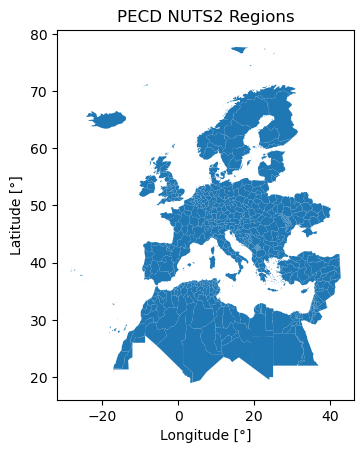

In [ ]:
# Reading polygon describing PECD NUTS 2 regions
shp_dir = "shape_files/custom_spatial_aggregation/"
shp = "NUT2_ADM1_PECD_fixed.shp"
gdf = gpd.read_file(shp_dir + shp)
gdf = gdf.rename(columns={"PECD_CODE": "NUTS2"})

ax = gdf.plot()

ax.set_title("PECD NUTS2 Regions")
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
plt.show()

## The need for a weighted spatial aggregation

### An overview


**Both solar resource and PV deployment can be characterized by spatial patterns**. For example, latitudes closer to the equator are characterized by a more abundant solar resource. And, at the same time, it is possible - but not necessarily true - that SPV deployment favors sunnier regions in order to achieve higher capacity factor values. Thus, **when aggregating the gridded data, the weighting of each region should reflect this**.

That would be the case for **France, for example, where PV deployment is strongly influenced by the quality of the solar resource available**.

### Continental France as an example


Thanks to the support of RTE, the French TSO, we were able to obtain an example dataset from a given year with the fraction of PV installed capacity for projects >1 MW** (i.e. utility-scale, being in France mostly the fixed type).

So let's start by filtering the PECD and polygon data accordingly:

                     FR10  FRB0  FRC1  FRC2  FRD1
Date                                             
2020-01-01 00:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 01:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 02:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 03:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 04:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 05:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 06:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 07:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 08:00:00  0.00  0.00  0.00  0.01   0.0
2020-01-01 09:00:00  0.01  0.01  0.06  0.14   0.0




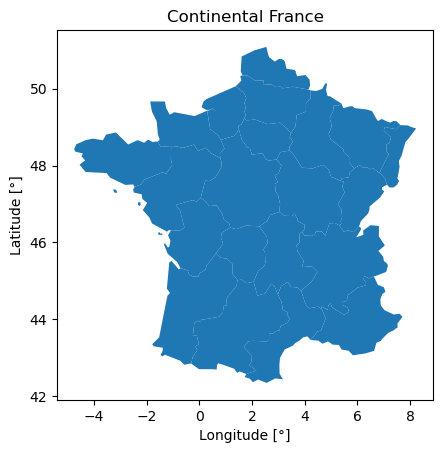

In [19]:
# Filtering PECD data
region_ix = [(arr[0:2] == "FR") & (arr != "FRM0") for arr in df.columns.values]
cf_fr = df.loc[:, region_ix]
print(cf_fr.iloc[:10, :5].round(2))

# prints blank line
print("\n")

# Filtering continental France
region_bool = [(arr[0:2] == "FR") & (arr != "FRM0") for arr in gdf.NUTS2.values]
nuts2 = gdf.loc[region_bool, :].set_index("NUTS2")
ax = nuts2.plot()

ax.set_title("Continental France")
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
plt.show()

Having this done, let's now read and visualize the installed capacity data (taking the chance to contrast it with the PECD):

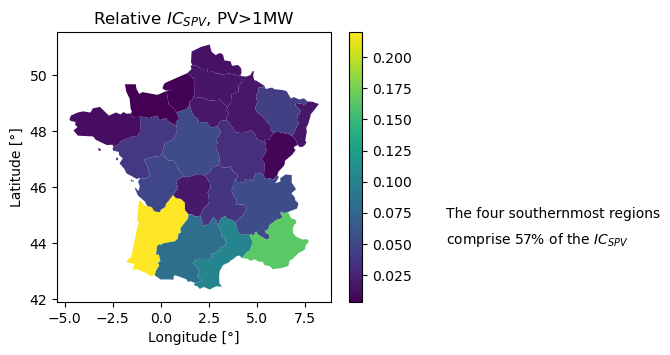

In [ ]:
# RTE data for NUTS 2 capacity relative weights (sum=1)
cap_weights = {
    "FR10": 0.017276,
    "FRB0": 0.053080,
    "FRC1": 0.032795,
    "FRC2": 0.006959,
    "FRD1": 0.003723,
    "FRD2": 0.005285,
    "FRE1": 0.013182,
    "FRE2": 0.015625,
    "FRF1": 0.016401,
    "FRF2": 0.016972,
    "FRF3": 0.043588,
    "FRG0": 0.038056,
    "FRH0": 0.011099,
    "FRI1": 0.219946,
    "FRI2": 0.018033,
    "FRI3": 0.049504,
    "FRJ1": 0.101388,
    "FRJ2": 0.081466,
    "FRK1": 0.037489,
    "FRK2": 0.053358,
    "FRL0": 0.164773,
}

ic_weights = pd.DataFrame.from_dict(cap_weights, orient="index", columns=["Weight"])

# add it to the geospatial dataframe that contained the polygons
nuts2 = pd.concat([nuts2, ic_weights], axis=1)

# visualize it
ax = nuts2.plot(column="Weight", legend=True, figsize=(4.5, 3.5))
ax.set_title("Relative $IC_{SPV}$, PV>1MW")
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")

val = (ic_weights.sort_values(by="Weight").iloc[-4:].values.sum() * 100).round(0).astype(int)

textstr = ["The four southernmost regions", "comprise {}% of the $IC_{}$".format(val, "{SPV}")]
for k in range(0, 2):
    plt.text(1, 0.35 - k * 0.075, textstr[k], transform=plt.gcf().transFigure)

plt.show()

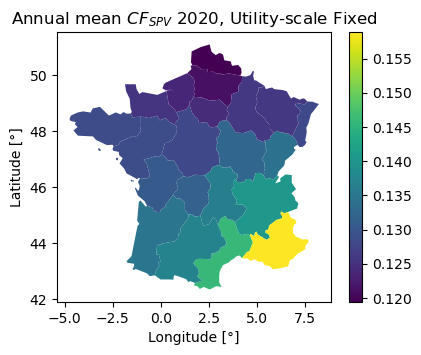

In [21]:
# append as well NUTS2 annual mean CF (2020)
nuts2 = pd.concat([nuts2, pd.DataFrame(cf_fr.mean(), columns=["CF"])], axis=1)

ax = nuts2.plot(column="CF", legend=True, figsize=(4.5, 3.5))
ax.set_title("Annual mean $CF_{SPV}$ 2020, Utility-scale Fixed")
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
plt.show()

The plots above confirm the initial assumption that PV deployment and capacity factors can have quite marked spatial patterns. Thus, accounting for where PV is deployed could be relevant for computing national-level timeseries.

However, since **there is no easily available IC data with sub-national resolution covering the whole PECD region, the implemented workflow had to follow the naive assumption that PV is homogeneously distributed** (although ignoring exclusion areas).

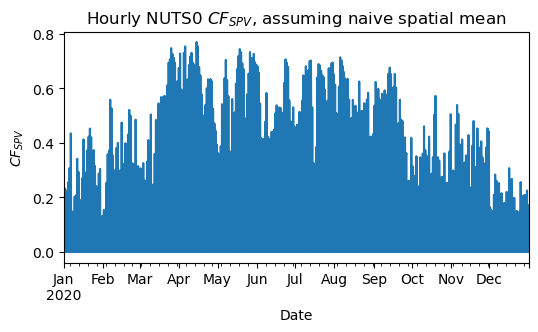

In [ ]:
# Naive spatial mean (assumes PV is equally present in every NUTS 2 region)
ax = cf_fr.mean(axis=1).plot(figsize=(6, 3))
ax.set_title("Hourly NUTS 0 $CF_{SPV}$, assuming naive spatial mean")
ax.set_ylabel("$CF_{SPV}$")
plt.show()

**In a case like France, this naive assumption is likely to underestimate the actual aggregated capacity factor** values, since it gives the same importante to less sunnier regions where there is less PV installed. 

Let's then compute the annual mean value for both a naive and a deployment-aware aggregation:

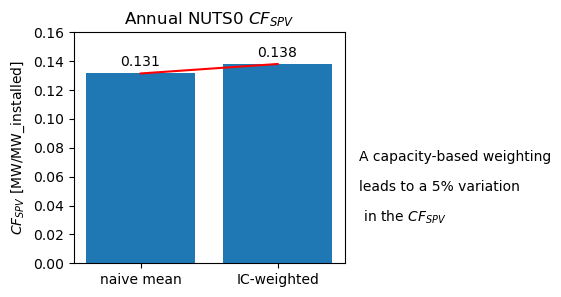

In [ ]:
annual_means = [
    cf_fr.mean(axis=1).values.mean(),  # naive spatial mean
    (cf_fr * ic_weights.squeeze()).sum(axis=1).values.mean(),  # IC-weighted spatial mean
]

delta = ((annual_means[1] / annual_means[0] - 1) * 100).round(0).astype(int)

# Labels
labels = ["naive mean", "IC-weighted"]

# Plot
plt.figure(figsize=(3.5, 3))
plt.bar(labels, annual_means)
plt.plot([0, 1], annual_means, color="r")
plt.ylim([0, 0.16])
plt.title("Annual NUTS 0 $CF_{SPV}$")
plt.ylabel("$CF_{SPV}$ [MW/MW_installed]")
plt.text(0 - 0.15, annual_means[0] + 0.005, annual_means[0].round(3))
plt.text(1 - 0.15, annual_means[1] + 0.005, annual_means[1].round(3))

textstr = [
    "A capacity-based weighting",
    "leads to a {}% variation".format(delta),
    " in the $CF_{}$".format("{SPV}"),
]
for k in range(0, 3):
    plt.text(0.94, 0.45 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

plt.show()
plt.close()

While we see an understimation at the annual level, how does this translate in terms of intra-annual seasonality?

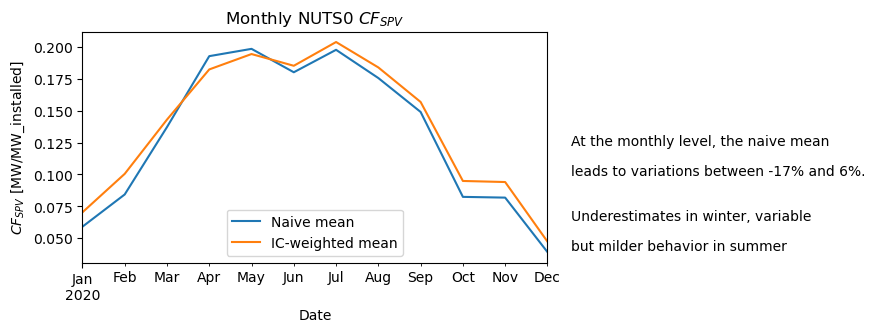

In [ ]:
# computes monthly means

# naive mean
a = cf_fr.mean(axis=1).groupby(pd.Grouper(freq="1ME")).mean()
# IC-weighted mean
b = (cf_fr * (ic_weights.squeeze())).sum(axis=1).groupby(pd.Grouper(freq="1ME")).mean()

# plots monthly means
a.plot(figsize=(6, 3), label="Naive mean")
b.plot(label="IC-weighted mean")
plt.title("Monthly NUTS 0 $CF_{SPV}$")
plt.legend()
plt.ylabel("$CF_{SPV}$ [MW/MW_installed]")

# min and max monthly relative deviations
range_ = (np.array([min(a / b - 1), max(a / b - 1)]) * 100).round(0).astype(int)

textstr = [
    "At the monthly level, the naive mean",
    f"leads to variations between {range_[0]}% and {range_[1]}%.",
]
for k in range(0, 2):
    plt.text(0.94, 0.5 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

textstr = ["Underestimates in winter, variable", "but milder behavior in summer"]
for k in range(0, 2):
    plt.text(0.94, 0.25 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

plt.show()

> **Additional note**:
> 
> While in France this does not seem to be the case, **different typologies can have different spatial patterns**. This can be driven by spatial variations in solar resource availability, land use, population and industry density, as well as regulatory/business practices.
>
> For example, in Portugal, self-consumption is more present near the coastline where people/services are, and in the North where there is more industry.

## Take home messages 📌


*   As no sub-national IC data for SPV is available for the whole PECD region, **gridded data is currently aggregated using a naive spatial mean** that assumes that SPV is equally present within a given territory (dismissing certain exclusion areas).
*   **When suitable IC data is available, it is easy to account for** a custom spatial weighting relying for example on the NUTS 2 aggregated data. A similar approach could be used for the raw gridded data, but unless data finer than NUTS 2 is available, it would lead to the same result while requiring the reading and processing of NetCDF files.
*   **A custom aggregation was done for France**, as an example, where PV prevails in the sunnier South. In this case, while it raises the annual CF, at the seasonal level the custom aggregation can both increase and decrease the CF values.
*   These results depend on the spatial patterns of both IC and CF.
*   **For SPV the IC spatial patterns can vary considerably from one country to another**, which asks for a broader data collection.